In [13]:
import numpy as np
from numpy.random import default_rng
random =default_rng(0)
from math import log
from matplotlib import pyplot as plt
import policy
from tqdm import tqdm
import bandit
from functools import partial
import experiment

# Bandit loop
We consider an agent interacting with a stochastic bandit, and we repeat the experience for a certain random of trials. The repetition process is vectorized so we avoid a for loop: we run the different trials in parallel.

## Reward generation at each round
Either we call the random generation routine, or we access a predefined table corresponding to the reward table model. This latter can reduce execution time at the price of memory allocation.


In [14]:
arm_means = 0.1*np.arange(1,11)
bandit_instance = bandit.StochasticBandit(arm_means, partial(random.binomial, 1))
bandit_experiment = experiment.StochasticBanditExperiment(horizon= 1000, repetitions= 100)
agent = policy.UCB1()
#policy_with_args = policy.kl_ucb
bandit_experiment.run_parallel(bandit_instance, agent, show_progress= True)

100%|██████████| 990/990 [00:00<00:00, 18351.68it/s]


In [15]:
agent.a

<function policy.SubGaussianBanditUCB.__init__.<locals>.<lambda>(u)>

# Plotting the regret
Having stored the rewards, there are two ways to estimate the expected regret:
* Taking the sum of the realized regrets (although in our case, the oracle's reward is already averaged), and then taking the average over experiments.
  $$R_{\text{realized}}(T) = \sum_{t=1}^T (r_{a^\star} - r_{a_t})$$
  where $r_{a_t} \sim \mathcal P_{a_t}$.
  
* Semi-realized regret, where a expecatation is taken for the oracle:
  $$R_{\text{realized}}(T) = \sum_{t=1}^T (\mu_{a^\star} - r_{a_t})$$
* Taking the sum of the expectation of regret conditional on the taken action, since we know the true mean
$$R_{\text{pseudo}}(T) = \sum_{t=1}^T (\mu_{a^\star} - \mu_{a_t}),$$
followed by an averaging over all trials. This way, we have a much smoother regret with a moderate number of trials.


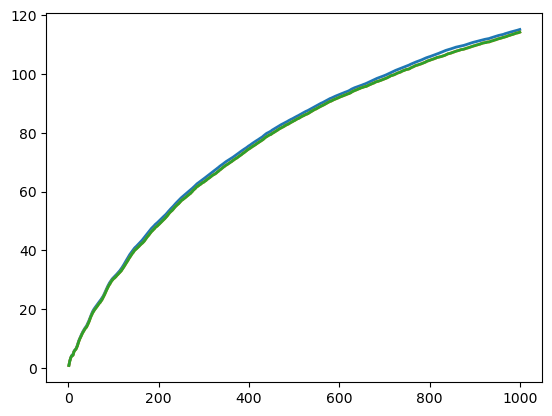

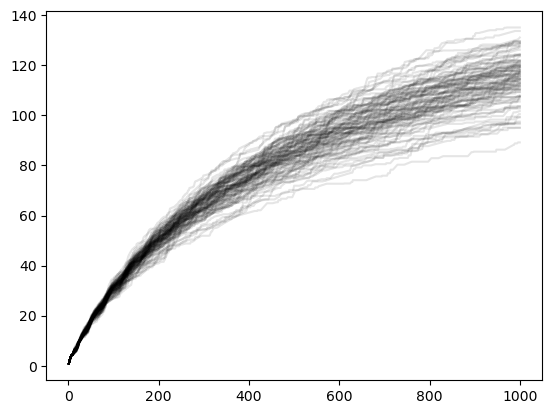

In [16]:
plt.figure()
horizon_range = (np.arange(bandit_experiment.horizon)+1)
realized_regret = experiment.compute_regret_old(bandit_experiment.reward_history, bandit_experiment.arm_history, bandit_instance, 'realized')#(oracle_realized_cumul_reward - agent_cumul_reward)
semi_realized_regret = experiment.compute_regret_old(bandit_experiment.reward_history, bandit_experiment.arm_history, bandit_instance, 'semi')
pseudo_regret = experiment.compute_regret_old(bandit_experiment.reward_history, bandit_experiment.arm_history, bandit_instance, 'pseudo')
plt.plot(horizon_range, pseudo_regret.mean(axis= 1), linewidth= 2, label= 'expected')
plt.plot(horizon_range, realized_regret.mean(axis= 1), linewidth= 2)
plt.plot(horizon_range, semi_realized_regret.mean(axis= 1), linewidth= 2)
plt.savefig("regret.png", format= "png")# %%

plt.figure()
#plt.plot(horizon_range, realized_regret, 'b', alpha= 0.1)
plt.plot(horizon_range, pseudo_regret, 'k', alpha= 0.1)
plt.savefig("regret_realizations.png", format= "png")# %%

# Regret plot

100%|██████████| 7/7 [00:01<00:00,  4.66it/s]


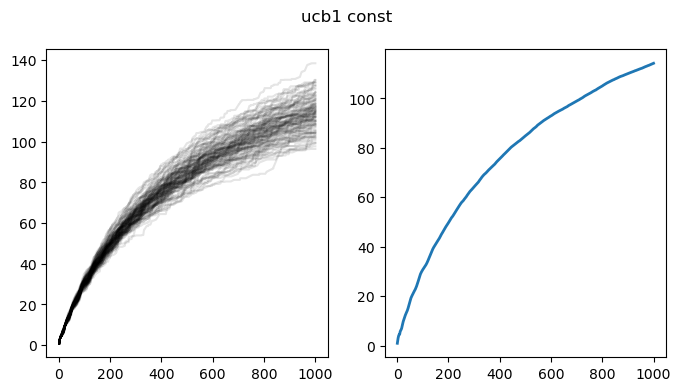

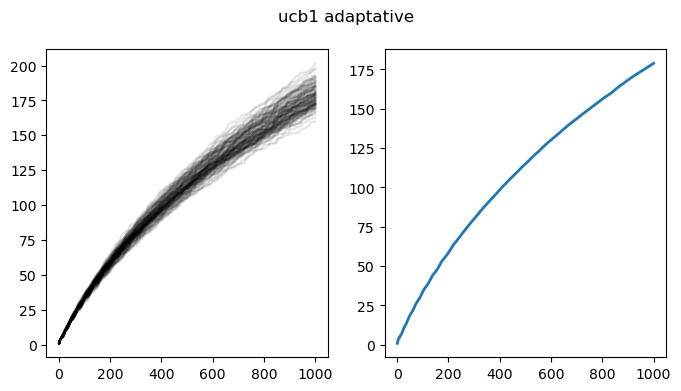

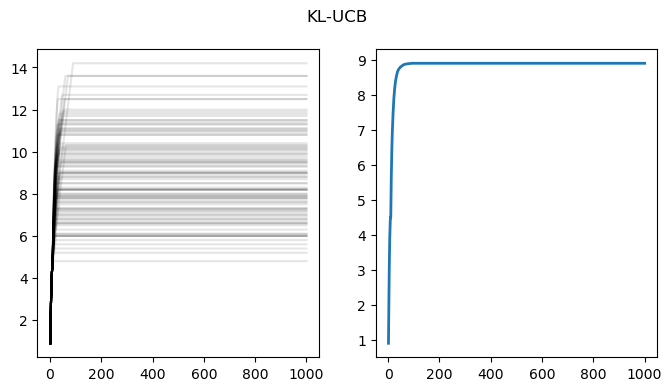

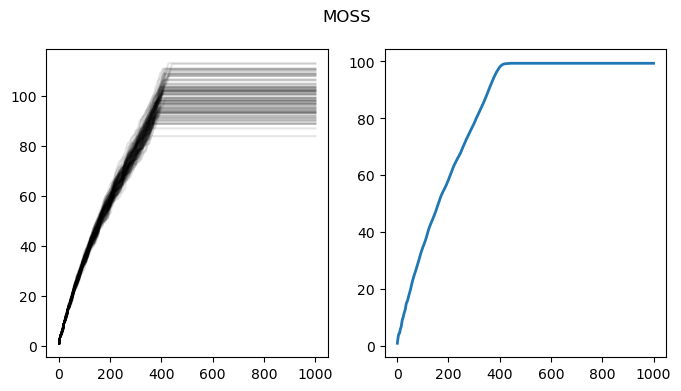

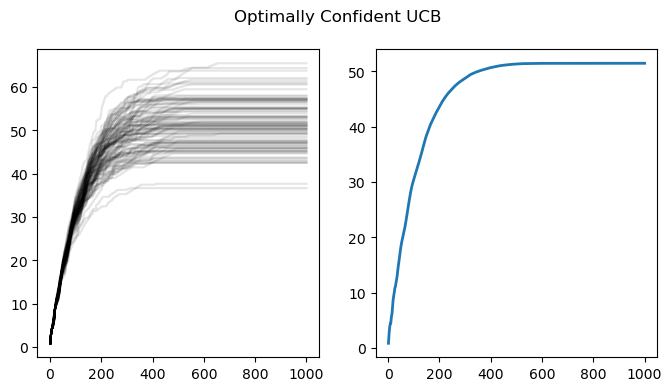

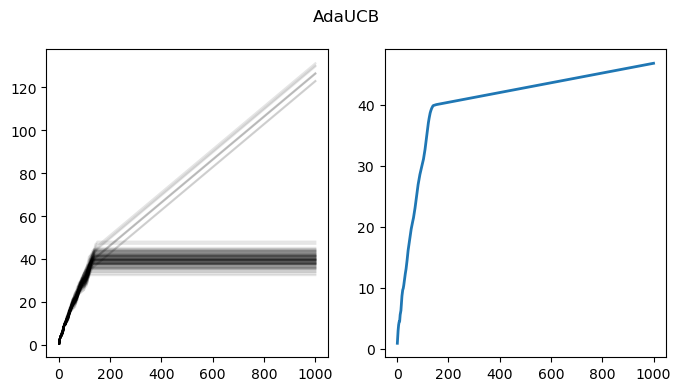

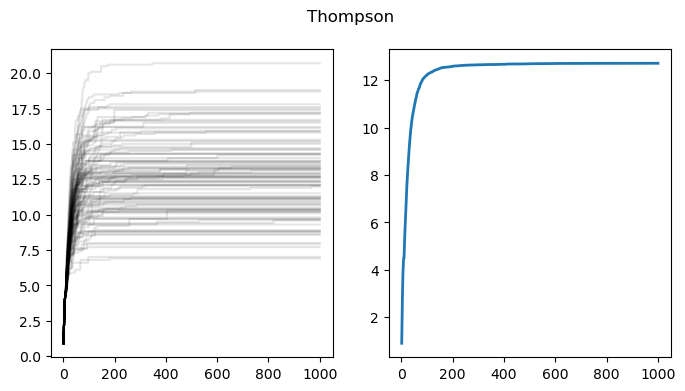

In [17]:
policy_dict = {
    "ucb1 const": policy.UCB1(),
    "ucb1 adaptative": policy.UCB1(a= lambda u: 1+u*log(u)**2),
    "KL-UCB": policy.KLUCB(),
    "MOSS": policy.MOSS(horizon_arms_ratio= bandit_experiment.horizon/len(bandit_instance.arm_means)),
    "Optimally Confident UCB": policy.OptimallyConfidentUCB(horizon= bandit_experiment.horizon),
    "AdaUCB": policy.AdaUCB(horizon= bandit_experiment.horizon),
    "Thompson": policy.ThompsonBernoulli(a= 1, b= 1),
}

for pol_name, pol in tqdm(policy_dict.items()):
    bandit_experiment.run_parallel(bandit_instance, pol)
    regret = bandit_experiment.compute_regret(bandit_instance, take_mean= False)
    fig, axs = plt.subplots(1, 2)
    fig.set_size_inches(8,4)
    axs[0].plot(horizon_range, regret, 'k', alpha= 0.1)
    axs[1].plot(horizon_range, regret.mean(axis= 1), linewidth= 2)
    fig.suptitle(pol_name)


In [18]:
experiment.horizon

AttributeError: module 'experiment' has no attribute 'horizon'